##üöÄdrive mounting

In [ ]:
environment='local' #[local|cloud]

if environment=='local':
  import os
  # Navigate to data dir mounted locally
  os.chdir('/data')

else:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

# %ls

##üìöimporting libraries

In [ ]:
# Set seed for reproducibility
seed = 44


# Import necessary libraries

import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.0


##üìäDataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
import numpy as np

data = np.load("filtered_mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
import gc
del data, training_set
gc.collect()

26

###visual inspection

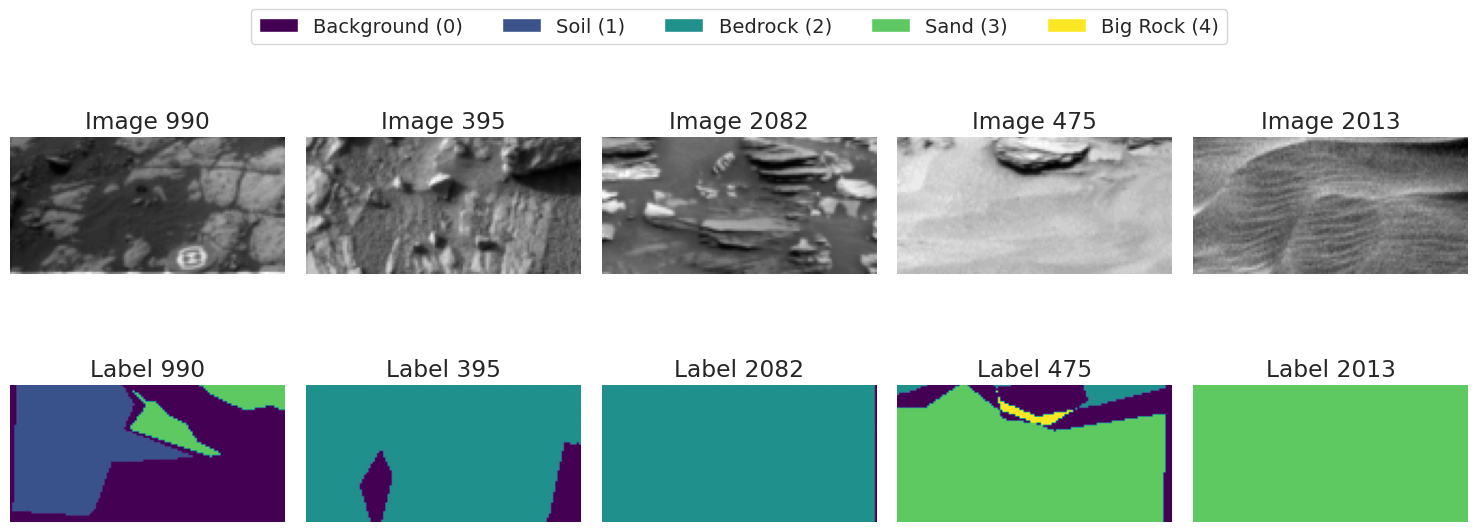

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Function to plot random images with labels
def plot_random_images_with_labels(images, labels, num=5):
    """
    Plots `num` random images with their respective label masks.

    Parameters:
        images (numpy.ndarray): Array of images.
        labels (numpy.ndarray): Array of label masks.
        num (int): Number of images to plot.
    """
    # Select `num` random indices
    random_indices = np.random.choice(len(images), num, replace=False)

    fig, axes = plt.subplots(2, num, figsize=(num * 3, 6))  # More compact figure

    for i, idx in enumerate(random_indices):
        # Display the image
        axes[0, i].imshow(images[idx], cmap='gray')
        axes[0, i].set_title(f"Image {idx}")
        axes[0, i].axis("off")

        # Display the mask with viridis
        axes[1, i].imshow(labels[idx], cmap='viridis', vmin=0, vmax=4)
        axes[1, i].set_title(f"Label {idx}")
        axes[1, i].axis("off")

    # Add a legend for the classes above the figure
    legend_elements = [
        Patch(facecolor=plt.cm.viridis(0 / 4), label='Background (0)'),
        Patch(facecolor=plt.cm.viridis(1 / 4), label='Soil (1)'),
        Patch(facecolor=plt.cm.viridis(2 / 4), label='Bedrock (2)'),
        Patch(facecolor=plt.cm.viridis(3 / 4), label='Sand (3)'),
        Patch(facecolor=plt.cm.viridis(4 / 4), label='Big Rock (4)')
    ]
    fig.legend(
        handles=legend_elements,
        loc='upper center',
        bbox_to_anchor=(0.5, 1.05),
        ncol=5,
        fontsize='medium'
    )

    plt.tight_layout()
    plt.show()

# Plot 5 random images with labels
plot_random_images_with_labels(X_train, y_train, num=5)


###data processing

We define a function to inspect and filter images and masks, removing samples where the background class (class 0) occupies more than a specified percentage of the image. The filtered dataset is then used for training, and the new size of the dataset is printed

In [ ]:
# Function to inspect all images and masks individually
def inspect_and_filter_samples(images, labels, threshold=0.98):
    valid_images = []
    valid_labels = []

    for i, (image, label) in enumerate(zip(images, labels)):
        # Count how many pixels have the value 0 (Background) in the mask
        background_count = np.sum(label == 0)
        total_pixels = label.size
        background_percentage = background_count / total_pixels

        # If class 0 occupies more than 50% of the image, discard the image
        if background_percentage > threshold:
            print(f"Immagine {i} eliminata per il background superiore al {threshold*100}%")
            continue

        valid_images.append(image)
        valid_labels.append(label)
    return np.array(valid_images), np.array(valid_labels)

# Perform dataset inspection
X_train_filtered, y_train_filtered = inspect_and_filter_samples(X_train, y_train)
X_train = X_train_filtered
y_train = y_train_filtered

# Print the size of the new splits
print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Labels: {len(y_train)}")


Immagine 2 eliminata per il background superiore al 98.0%
Immagine 3 eliminata per il background superiore al 98.0%
Immagine 4 eliminata per il background superiore al 98.0%
Immagine 42 eliminata per il background superiore al 98.0%
Immagine 61 eliminata per il background superiore al 98.0%
Immagine 89 eliminata per il background superiore al 98.0%
Immagine 117 eliminata per il background superiore al 98.0%
Immagine 120 eliminata per il background superiore al 98.0%
Immagine 130 eliminata per il background superiore al 98.0%
Immagine 351 eliminata per il background superiore al 98.0%
Immagine 385 eliminata per il background superiore al 98.0%
Immagine 387 eliminata per il background superiore al 98.0%
Immagine 409 eliminata per il background superiore al 98.0%
Immagine 459 eliminata per il background superiore al 98.0%
Immagine 472 eliminata per il background superiore al 98.0%
Immagine 508 eliminata per il background superiore al 98.0%
Immagine 512 eliminata per il background superior

In [ ]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Distribuzione delle classi: {0.0: 4370412, 1.0: 6955656, 2.0: 4775288, 3.0: 3770086, 4.0: 26926}


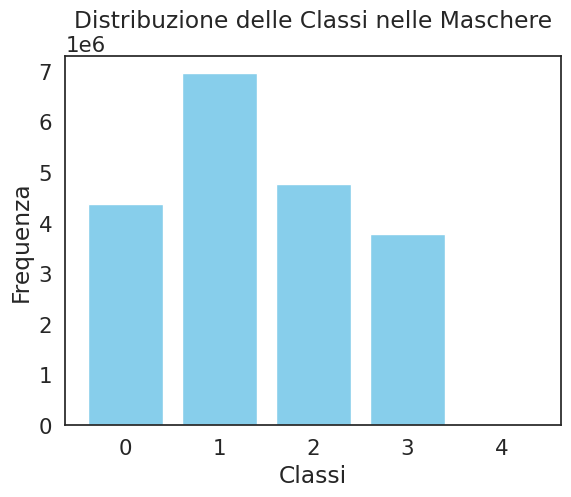

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar plot
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


In [ ]:
from sklearn.model_selection import train_test_split

# First split: division between train and temp (which will become validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Second split: division between validation and test
X_val, X_test_tmp, y_val, y_test_tmp = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the size of the new splits
print(f"Number of images:")
print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test_tmp)}")


Number of images:
Train: 1943
Validation: 243
Test: 243


Distribuzione delle classi: {0.0: 3425990, 1.0: 5657980, 2.0: 3814815, 3.0: 2999052, 4.0: 19219}


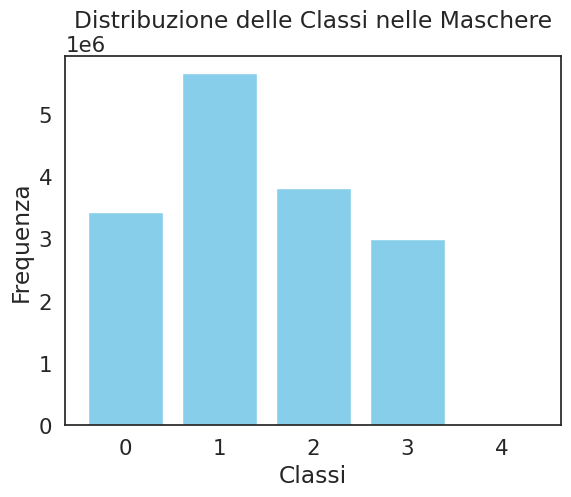

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate class frequencies
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar plot
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")

It is clear that there are classes that are highly represented, while others are significantly less represented

###preparing the dataset

We prepare the training dataset (applying geometric augmentation such as random flipping), the validation dataset, and the test dataset. Additionally, we set essential parameters such as batch size, patience, number of epochs, and learning rate

In [ ]:
@tf.function
def random_flip(image, label, seed=None):
    """
    Random horizontal flip for image and its corresponding segmentation mask (label).
    Displays three images with masks before and after the flip.

    Args:
        image: Tensor representing the image, shape [H, W, C].
        label: Tensor representing the segmentation mask, shape [H, W] or [H, W, 1].
        seed: Optional seed for the random generator.

    Returns:
        Flipped (or unchanged) image and label.
    """
    # Generate a random seed if not provided
    if seed is None:
        seed = np.random.randint(0, 1000000)

    # Ensure the label has 3 dimensions
    if len(label.shape) == 2:  # Adds a channel dimension
        label = tf.expand_dims(label, axis=-1)

    # Save copies of the original images and masks for visualization
    original_image = image.numpy() if tf.executing_eagerly() else image
    original_label = label.numpy() if tf.executing_eagerly() else label

    # Random uniform to determine the flip
    flip_prob = tf.random.uniform([], seed=seed)

    # Apply the conditional horizontal flip
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )

    return image, label


In [ ]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

In [ ]:
import numpy as np

# Add the channel to X_train and X_test
X_train = np.expand_dims(X_train, axis=-1)  # Add a channel
X_test_tmp = np.expand_dims(X_test_tmp, axis=-1)  # Add a channel
X_val = np.expand_dims(X_val, axis=-1)

input_shape = X_train.shape[1:]  # The input shape (excluding batch dimension)
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Input shape: (64, 128, 1)
Number of classes: 5


In [ ]:
import tensorflow as tf

def make_dataset(X_train, y_train, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset from X_train and y_train.

    Parameters:
    - X_train: Training images.
    - y_train: Training labels.
    - batch_size: Number of elements per batch.
    - shuffle: If True, shuffles the dataset.
    - augment: If True, applies augmentations to the images.
    - seed: Seed for randomness (optional).

    Returns:
    - dataset: TensorFlow dataset.
    """

    # Add the fourth dimension to y_train if necessary
    if len(y_train.shape) == 3:  # If y_train has shape (n_samples, height, width)
        y_train = tf.expand_dims(y_train, axis=-1)  # Converts to (n_samples, height, width, 1)

    # Create a dataset from X_train and y_train
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Apply shuffling
    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size, seed=seed)

    # Apply augmentations
    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )


    # Perform batching
    dataset = dataset.batch(batch_size, drop_remainder=False)

    # Optimize data loading
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [ ]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    X_test_tmp, y_test_tmp,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (64, 64, 128, 1)
Labels shape: (64, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


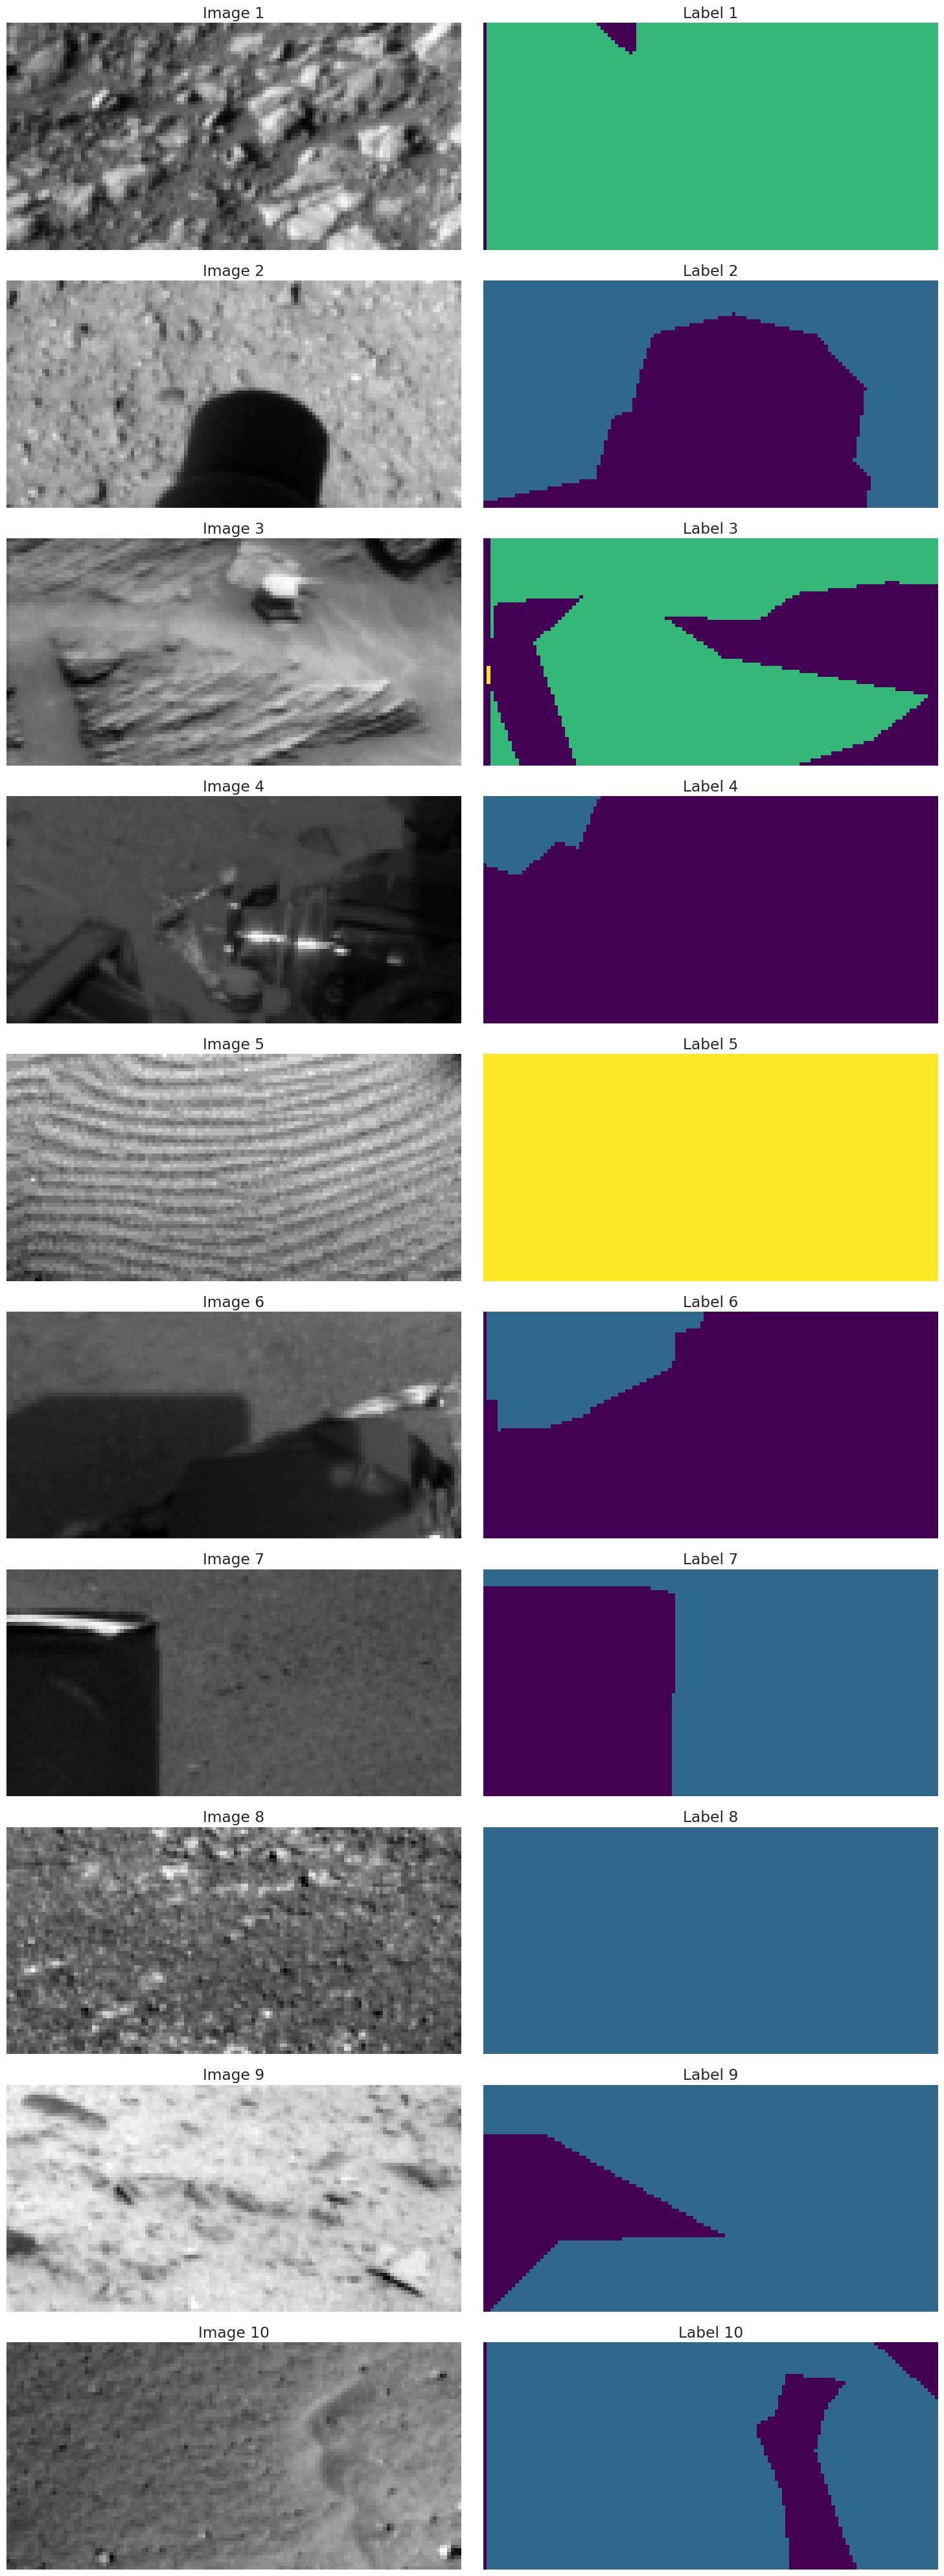

In [ ]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(tf.squeeze(images[j], axis=-1)*255, cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=10)

Above are examples of the training dataset created

##üí°Model

We define a U-Net model with 3 downsampling layers and 3 upsampling layers (using a basic U-block). In each upsampling layer, we add an attention block. In the bottleneck, we implement an improved ASPP layer

In [ ]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x


def improved_aspp_block(input_tensor, filters=128, dropout_rate=0.3):
    """
    Improved Atrous Spatial Pyramid Pooling (ASPP) Block with added normalization,
    adaptive filters, and multi-level regularization.
    """
    # 1x1 Convolution
    conv_1x1 = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(input_tensor)
    conv_1x1 = tfkl.BatchNormalization()(conv_1x1)

    # Dilated convolutions
    conv_3x3_1 = tfkl.Conv2D(filters, (3, 3), dilation_rate=6, padding="same", activation="relu")(input_tensor)
    conv_3x3_1 = tfkl.BatchNormalization()(conv_3x3_1)

    conv_3x3_2 = tfkl.Conv2D(filters, (3, 3), dilation_rate=12, padding="same", activation="relu")(input_tensor)
    conv_3x3_2 = tfkl.BatchNormalization()(conv_3x3_2)

    conv_3x3_3 = tfkl.Conv2D(filters, (3, 3), dilation_rate=18, padding="same", activation="relu")(input_tensor)
    conv_3x3_3 = tfkl.BatchNormalization()(conv_3x3_3)

    # Global Average Pooling
    gap = tfkl.GlobalAveragePooling2D()(input_tensor)
    gap = tfkl.Reshape((1, 1, input_tensor.shape[-1]))(gap)
    gap = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(gap)
    gap = tfkl.BatchNormalization()(gap)
    gap = tfkl.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]))(gap)

    # Concatenate all branches
    x = tfkl.Concatenate()([conv_1x1, conv_3x3_1, conv_3x3_2, conv_3x3_3, gap])

    # Final 1x1 Convolution to combine features
    x = tfkl.Conv2D(filters, (1, 1), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    # Add multiple levels of Dropout
    x = tfkl.Dropout(dropout_rate)(x)  # Standard Dropout
    x = tfkl.SpatialDropout2D(dropout_rate)(x)  # Spatial Dropout

    return x



def attention_block(x, g, inter_channel):
    """
    Attention Gate: Modulates features in skip connections using gating signals.
    Args:
        x: Feature map from the encoder (skip connection input).
        g: Gating signal from the decoder.
        inter_channel: Number of filters for intermediate computations.
    Returns:
        Modified feature map with attention applied.
    """
    theta_x = tfkl.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = tfkl.Conv2D(inter_channel, (1, 1), strides=(1, 1), padding='same')(g)

    add_xg = tfkl.Add()([theta_x, phi_g])
    act_xg = tfkl.Activation('relu')(add_xg)
    psi = tfkl.Conv2D(1, (1, 1), strides=(1, 1), padding='same')(act_xg)
    sigmoid_psi = tfkl.Activation('sigmoid')(psi)

    return tfkl.Multiply()([x, sigmoid_psi])

def get_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    """U-Net Model with 3 Downsampling and 3 Upsampling Blocks using Add instead of Concatenate"""
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')
    d3 = tfkl.MaxPooling2D()(down_block_3)

    # Bottleneck with ASPP
    # Bottleneck
    bottleneck = improved_aspp_block(d3, filters=256, dropout_rate=0.4)

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    #u1 = tfkl.Conv2D(128, kernel_size=1, padding='same', name='adjust_u1_channels')(u1)  # Match channels
    #u1 = tfkl.Add()([u1, down_block_3])
    a1= attention_block(down_block_3, u1, 128)
    u1 = tfkl.Concatenate()([u1, a1])
    u1 = unet_block(u1, 128, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    #u2 = tfkl.Conv2D(64, kernel_size=1, padding='same', name='adjust_u2_channels')(u2)  # Match channels
    #u2 = tfkl.Add()([u2, down_block_2])
    a2= attention_block(down_block_2, u2, 64)
    u2 = tfkl.Concatenate()([u2, a2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u3 = tfkl.UpSampling2D()(u2)
    #u3 = tfkl.Conv2D(32, kernel_size=1, padding='same', name='adjust_u3_channels')(u3)  # Match channels
    #u3 = tfkl.Add()([u3, down_block_1])
    a3= attention_block(down_block_1, u3, 32)
    u3 = tfkl.Concatenate()([u3, a3])
    u3 = unet_block(u3, 32, name='up_block3_')

    # Add Spatial Dropout in the Decoder Path
    u3 = tfkl.SpatialDropout2D(rate=0.4)(u3)

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u3)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

We load a pre-trained U-Net model (with the same architecture) and freeze specific layers (e.g., the downsampling path) to prevent them from being updated during training. The rest of the layers remain trainable

Model: "UNet"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)              ‚îÉ Output Shape           ‚îÉ        Param # ‚îÉ Connected to           ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer (InputLayer)  ‚îÇ (None, 64, 128, 1)     ‚îÇ              0 ‚îÇ -                      ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_conv1         ‚îÇ (None, 64, 128, 32)    ‚îÇ            320 ‚îÇ input_layer[0][0]      ‚îÇ
‚îÇ (Conv2D)                  ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_bn1           ‚îÇ (None, 64, 128, 32)    ‚îÇ            128 ‚îÇ down_block1_conv1[0][‚Ä¶ ‚îÇ
‚îÇ (BatchNormalization)      ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_activation1   ‚îÇ (None, 64, 128, 32)    ‚îÇ              0 ‚îÇ down_block1_bn1[0][0]  ‚îÇ
‚îÇ (Activation)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_conv2         ‚îÇ (None, 64, 128, 32)    ‚îÇ          9,248 ‚îÇ down_block1_activatio‚Ä¶ ‚îÇ
‚îÇ (Conv2D)                  ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_bn2           ‚îÇ (None, 64, 128, 32)    ‚îÇ            128 ‚îÇ down_block1_conv2[0][‚Ä¶ ‚îÇ
‚îÇ (BatchNormalization)      ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_activation2   ‚îÇ (None, 64, 128, 32)    ‚îÇ              0 ‚îÇ down_block1_bn2[0][0]  ‚îÇ
‚îÇ (Activation)              ‚îÇ                        ‚îÇ                ‚îÇ                        ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 2,415,592 (9.21 MB)

 Trainable params: 2,123,400 (8.10 MB)

 Non-trainable params: 292,192 (1.11 MB)

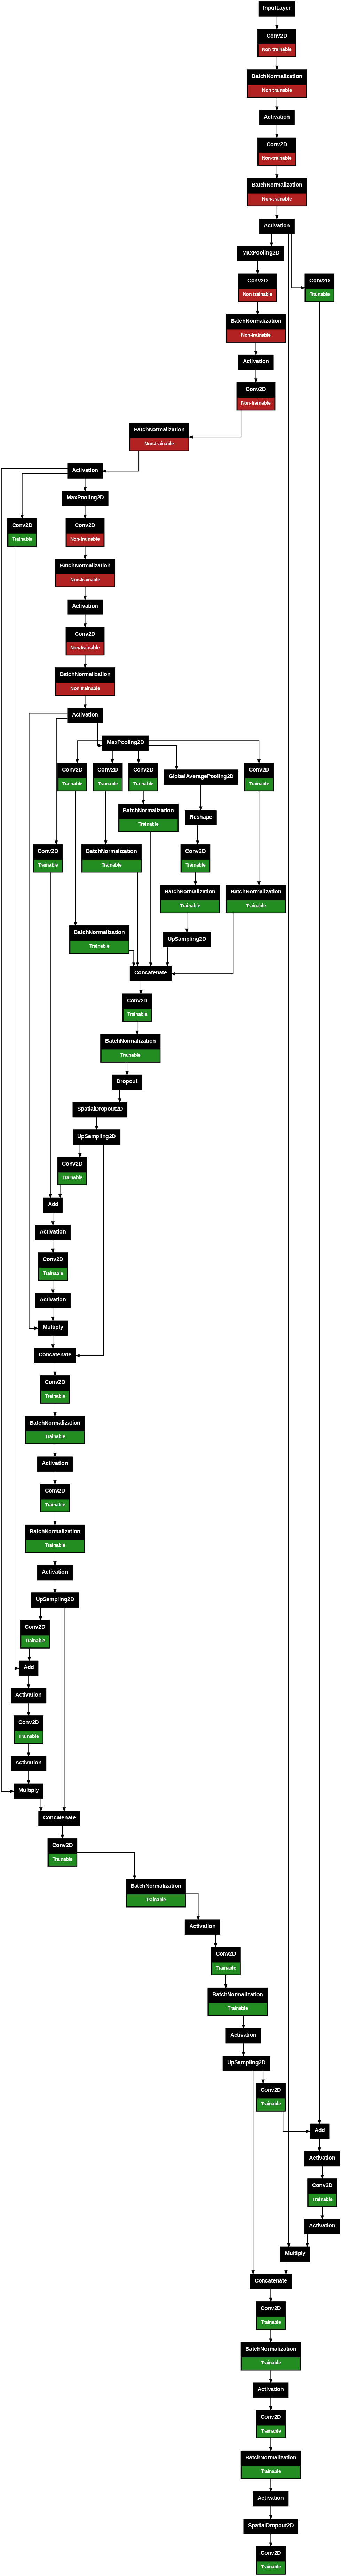

In [ ]:
# Creazione del modello
model = get_unet_model()
weights_filename = 'UNet_weights_56.45.weights.h5'
model.load_weights(weights_filename)

# Freeze specific layers (e.g., encoder or downsampling path)
for layer in model.layers:
    if 'down_block' in layer.name:  # Adjust the prefix to match your layer naming convention
        layer.trainable = False  # Freeze encoder layers
    else:
        layer.trainable = True  # Keep other layers trainable

model.summary()


# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Above, you can see the structure of the created model and the number of parameters

We define the MIoU (Mean Intersection over Union) and the Viz Callback to monitor the model's performance during training. MIoU is used as a metric to evaluate the accuracy of pixel-wise segmentation, while the Viz Callback helps visualize the model's predictions in real-time, providing insights into the training process.

In [ ]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)


In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, sample_images, sample_labels, frequency=5):
        """
        Visualization callback to monitor predictions during training.

        Args:
        - sample_images: A list of two NumPy arrays, each representing an image.
        - sample_labels: A list of two NumPy arrays, each representing a segmentation mask.
        - frequency: Frequency in terms of epochs to display the results.
        """
        super().__init__()
        self.sample_images = sample_images  # List of two images
        self.sample_labels = sample_labels  # List of two masks
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        """
        Displays the predictions at the end of every `frequency` epochs.
        """
        if epoch % self.frequency == 0:
            num_samples = len(self.sample_images)

            # Create the colormap
            num_classes = self.model.output_shape[-1]  # Number of classes from the model
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4 * num_samples))  # Expands the vertical size for more images

            for i in range(num_samples):
                image = tf.expand_dims(self.sample_images[i], 0)  # Adds batch dimension
                label = self.sample_labels[i]  # Associated label

                # Generate prediction
                pred = self.model.predict(image, verbose=0)
                y_pred = tf.math.argmax(pred, axis=-1)
                y_pred = y_pred.numpy()[0]  # Removes batch dimension

                # Input image
                plt.subplot(num_samples, 3, i * 3 + 1)
                plt.imshow(tf.squeeze(self.sample_images[i]), cmap='gray')
                plt.title(f"Input Image {i + 1}")
                plt.axis('off')

                # Ground truth
                plt.subplot(num_samples, 3, i * 3 + 2)
                colored_label = apply_colormap(label, colormap)
                plt.imshow(colored_label)
                plt.title(f"Ground Truth Mask {i + 1}")
                plt.axis('off')

                # Prediction
                plt.subplot(num_samples, 3, i * 3 + 3)
                colored_pred = apply_colormap(y_pred, colormap)
                plt.imshow(colored_pred)
                plt.title(f"Predicted Mask {i + 1}")
                plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


sample_images = [X_val[0], X_val[1]]
sample_labels = [y_val[0], y_val[1]]
viz_callback = VizCallback(sample_images, sample_labels, frequency=5)


In [ ]:


# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

We compute class weights to address class imbalance and normalize them into alpha. This alpha is then used in the custom Sparse Categorical Focal Loss function, which emphasizes harder examples during training. The custom loss function adjusts the impact of each class and focuses on improving model performance on difficult-to-classify samples

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np # Import numpy

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1, 2, 3, 4]),  # Convert the list to a NumPy array
    y=y_train.flatten(),  # y_train deve essere in formato 1D
)
alpha = class_weights / sum(class_weights)
print(alpha)

[0.00549733 0.00332871 0.00493701 0.00627992 0.97995703]


In [ ]:
class SparseCategoricalFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, name="sparse_categorical_focal_loss"):
        """
        Implements the Focal Loss for integer labels.

        Parameters:
        - gamma: Modulates the balance between easy and hard examples.
        - alpha: Balances the contribution of classes (e.g., for class imbalance).
        """
        super().__init__(name=name)
        self.gamma = gamma
        self.alpha = alpha  # Store alpha as an attribute, but don't calculate it here

    def call(self, y_true, y_pred):
        # Calculate alpha inside the call method if it's not provided
        if self.alpha is None:
            classes, counts = np.unique(y_train, return_counts=True)
            class_weights = compute_class_weight(
                class_weight="balanced",
                classes=np.array([0, 1, 2, 3, 4]),
                y=y_train.flatten()
            )
            alpha = class_weights / sum(class_weights)
        else:
            alpha = self.alpha  # Use the provided alpha if available

        alpha = tf.cast(alpha, tf.float32)  # Cast alpha to tf.float32

        # Convert predicted probabilities to log probabilities
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)  # Avoid log(0)

        # Calculate the probability of the true class
        one_hot_y_true = tf.one_hot(tf.cast(y_true[..., 0], tf.int32), depth=y_pred.shape[-1])
        true_prob = tf.reduce_sum(y_pred * one_hot_y_true, axis=-1)

        # Apply the Focal Loss
        weight = tf.pow(1.0 - true_prob, self.gamma)  # Focus on hard examples

        # Reshape alpha to match the shape of weight
        alpha_reshaped = tf.gather(alpha, tf.cast(y_true[..., 0], tf.int32))  # Gather alpha values for true classes
        # alpha_reshaped = tf.reshape(self.alpha, [1, 1, -1]) # Reshape alpha to (1, 1, num_classes)
        # alpha_reshaped = tf.broadcast_to(alpha_reshaped, tf.shape(y_pred)) # Broadcast to match y_pred

        focal_loss = -alpha_reshaped * weight * tf.math.log(true_prob)

        return tf.reduce_mean(focal_loss)

    # Updated get_config method
    def get_config(self):
        """
        Returns the configuration of the loss function.
        """
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha.tolist() if self.alpha is not None else None  # Ensure serializable type
        })
        return config

    @classmethod
    def from_config(cls, config):
        """
        Creates a loss instance from the configuration.
        """
        return cls(**config)


We define a cosine decay learning rate schedule with a warmup phase, starting at 1e-5 and decaying to 1e-6 over time

In [ ]:
# Compile the model

import keras
reduce_lr = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    decay_steps=120*32,
    alpha=1e-6,
    name="CosineDecay",
    warmup_target=1e-4,
    warmup_steps=120*32*0.1,
)
'''
reduce_lr=keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=120*32,
    decay_rate=0.96,
    staircase=False,
    name="ExponentialDecay",
)
'''

print("Compiling model...")
model.compile(
    loss=SparseCategoricalFocalLoss,
    optimizer = tf.keras.optimizers.AdamW(
    learning_rate=reduce_lr,
    weight_decay=1e-4),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)
print("Model compiled!")

Compiling model...
Model compiled!


###training

We can train the model, also using early stopping to prevent overfitting and reduce computational time

Epoch 1/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 751ms/step - accuracy: 0.8126 - loss: 0.0012 - mean_iou: 0.6282

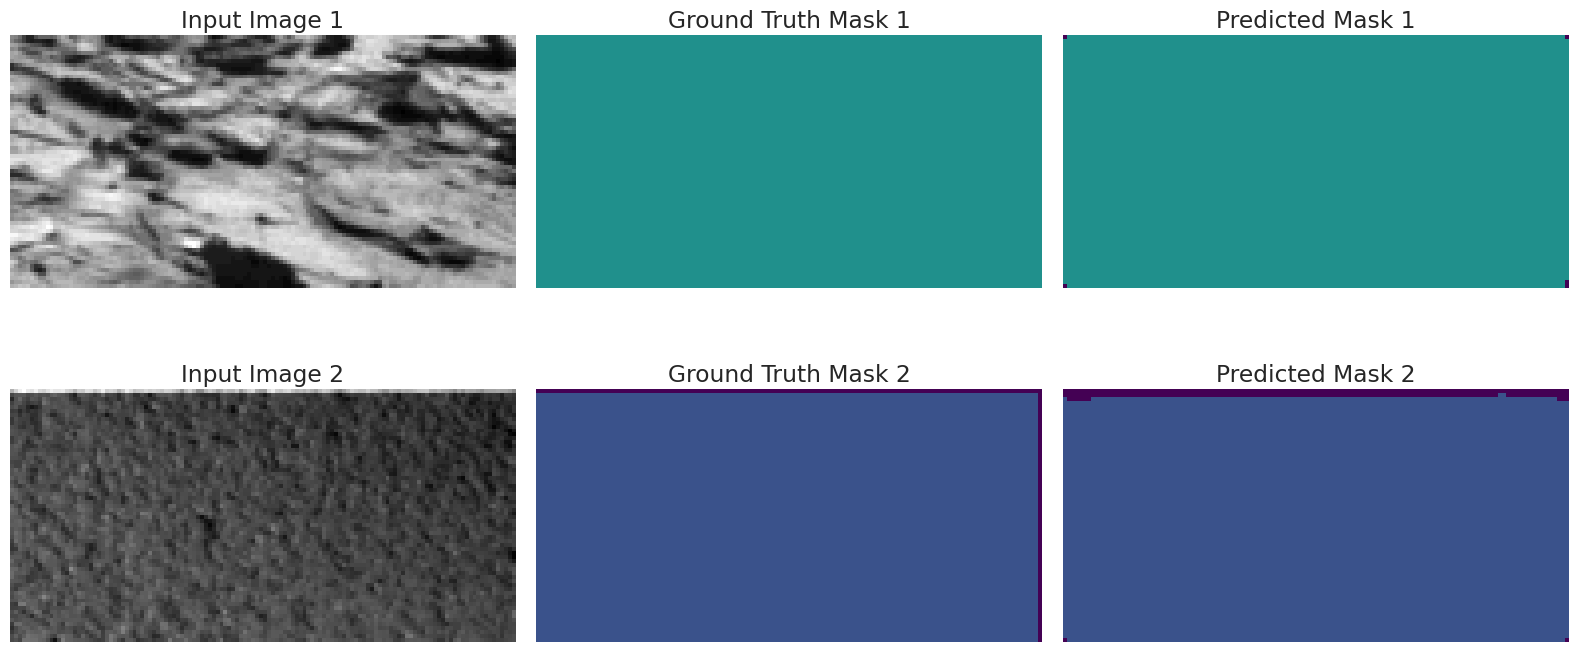

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 89s 2s/step - accuracy: 0.8126 - loss: 0.0012 - mean_iou: 0.6285 - val_accuracy: 0.8193 - val_loss: 0.0021 - val_mean_iou: 0.6761
Epoch 2/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 122ms/step - accuracy: 0.8129 - loss: 0.0013 - mean_iou: 0.6196 - val_accuracy: 0.8192 - val_loss: 0.0020 - val_mean_iou: 0.6772
Epoch 3/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 122ms/step - accuracy: 0.8121 - loss: 0.0012 - mean_iou: 0.6229 - val_accuracy: 0.8191 - val_loss: 0.0019 - val_mean_iou: 0.6765
Epoch 4/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 122ms/step - accuracy: 0.8176 - loss: 0.0012 - mean_iou: 0.6256 - val_accuracy: 0.8190 - val_loss: 0.0018 - val_mean_iou: 0.6738
Epoch 5/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 121ms/step - accuracy: 0.8109 - loss: 0.0012 - mean_iou: 0.5955 - val_accuracy: 0.81

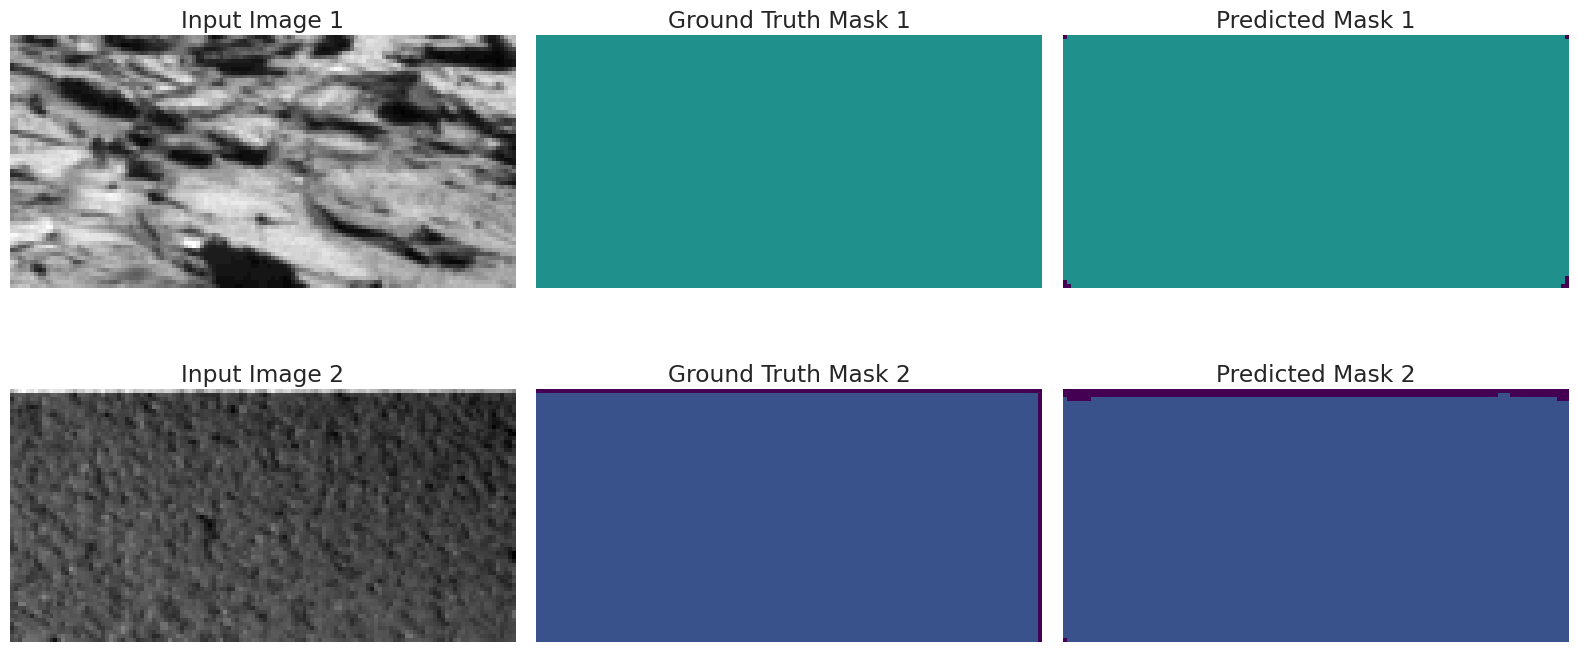

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 152ms/step - accuracy: 0.8128 - loss: 0.0011 - mean_iou: 0.6002 - val_accuracy: 0.8177 - val_loss: 0.0018 - val_mean_iou: 0.6713
Epoch 7/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 124ms/step - accuracy: 0.8178 - loss: 0.0011 - mean_iou: 0.6218 - val_accuracy: 0.8174 - val_loss: 0.0018 - val_mean_iou: 0.6751
Epoch 8/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8113 - loss: 0.0011 - mean_iou: 0.6058 - val_accuracy: 0.8197 - val_loss: 0.0018 - val_mean_iou: 0.6759
Epoch 9/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 122ms/step - accuracy: 0.8163 - loss: 0.0011 - mean_iou: 0.6117 - val_accuracy: 0.8201 - val_loss: 0.0018 - val_mean_iou: 0.6655
Epoch 10/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 122ms/step - accuracy: 0.8168 - loss: 0.0011 - mean_iou: 0.5980 - val_accuracy: 0

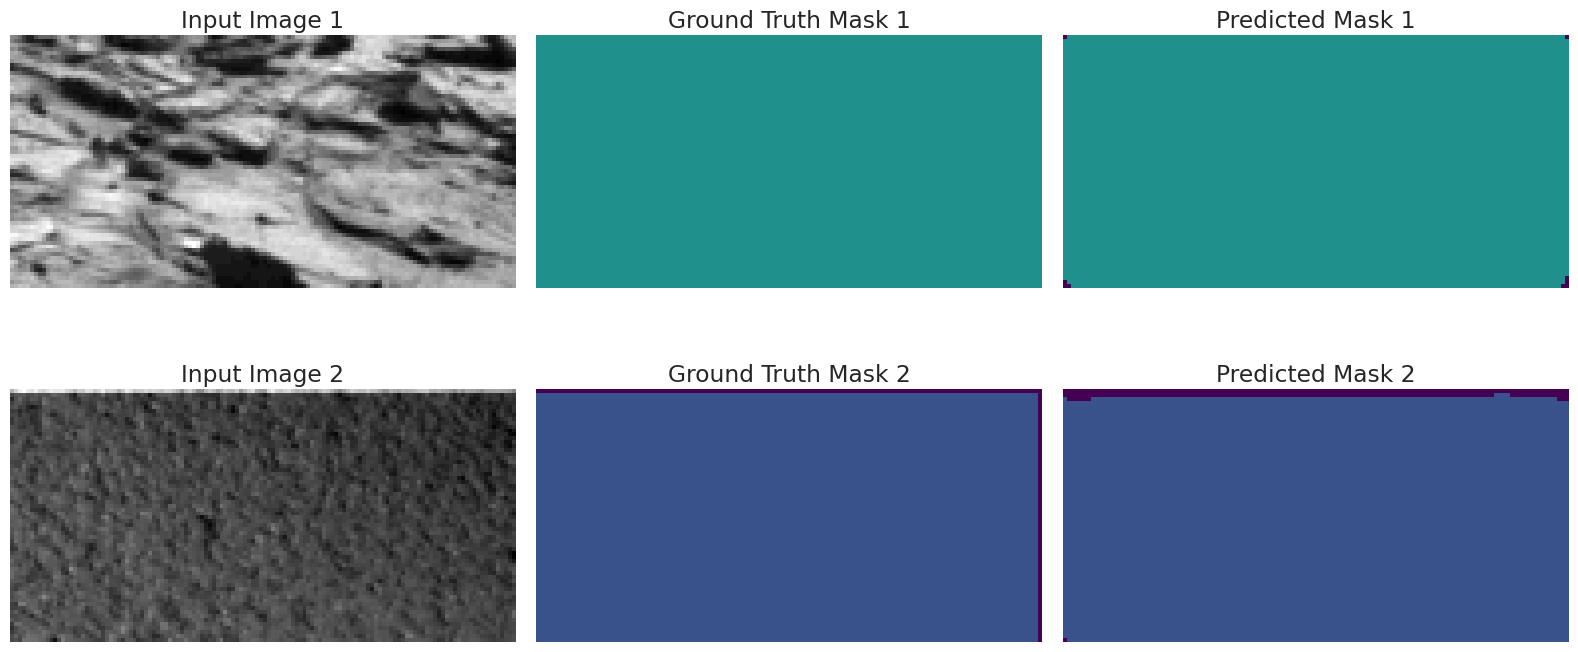

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 145ms/step - accuracy: 0.8136 - loss: 0.0011 - mean_iou: 0.5911 - val_accuracy: 0.8191 - val_loss: 0.0019 - val_mean_iou: 0.6540
Epoch 12/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8127 - loss: 0.0011 - mean_iou: 0.5858 - val_accuracy: 0.8176 - val_loss: 0.0018 - val_mean_iou: 0.6506
Epoch 13/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8110 - loss: 0.0010 - mean_iou: 0.5792 - val_accuracy: 0.8159 - val_loss: 0.0017 - val_mean_iou: 0.6457
Epoch 14/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8170 - loss: 9.7553e-04 - mean_iou: 0.5951 - val_accuracy: 0.8160 - val_loss: 0.0018 - val_mean_iou: 0.6557
Epoch 15/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8178 - loss: 9.9142e-04 - mean_iou: 0.6175 - val_

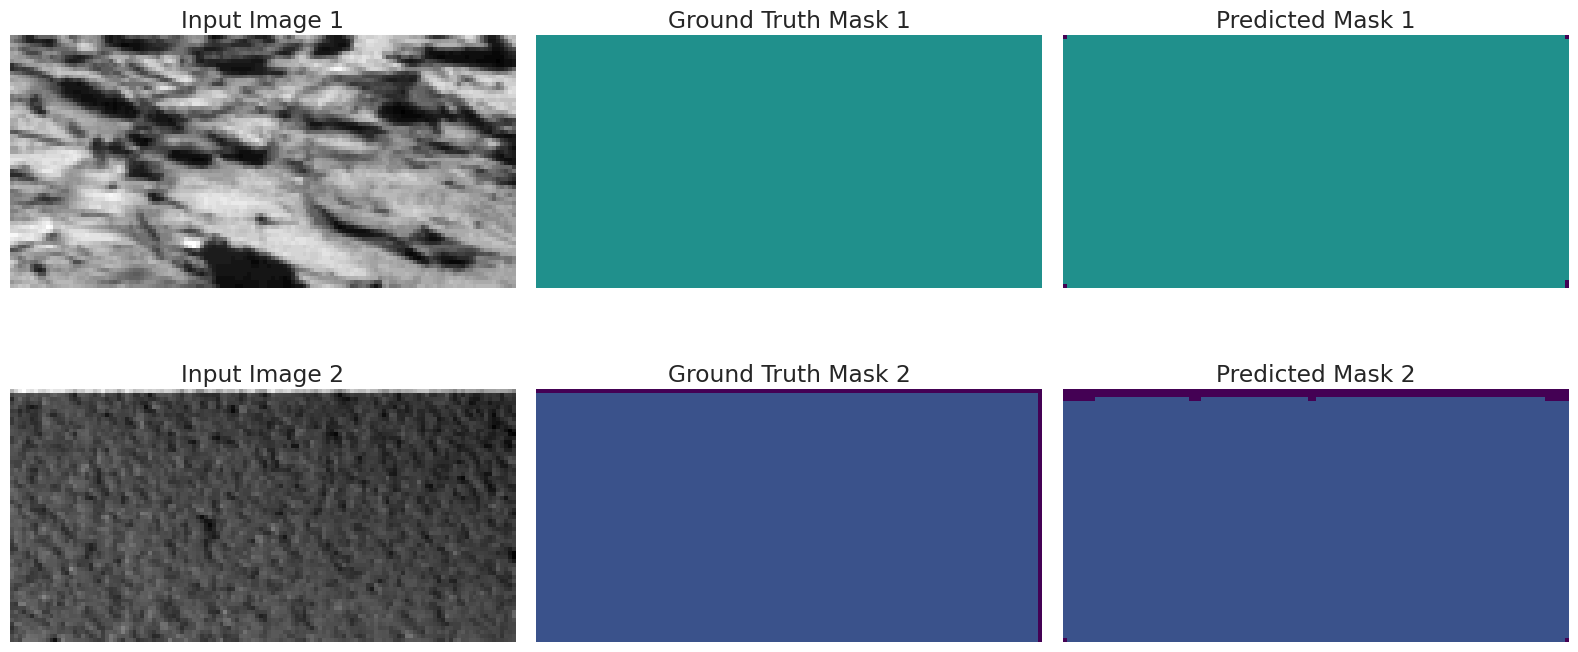

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 146ms/step - accuracy: 0.8197 - loss: 9.7649e-04 - mean_iou: 0.6071 - val_accuracy: 0.8156 - val_loss: 0.0018 - val_mean_iou: 0.6475
Epoch 17/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8196 - loss: 9.9915e-04 - mean_iou: 0.6030 - val_accuracy: 0.8107 - val_loss: 0.0017 - val_mean_iou: 0.6150
Epoch 18/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8203 - loss: 9.8773e-04 - mean_iou: 0.5810 - val_accuracy: 0.8149 - val_loss: 0.0018 - val_mean_iou: 0.6395
Epoch 19/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8209 - loss: 9.8940e-04 - mean_iou: 0.6047 - val_accuracy: 0.8144 - val_loss: 0.0018 - val_mean_iou: 0.6350
Epoch 20/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8172 - loss: 9.6799e-04 - mean_iou: 0

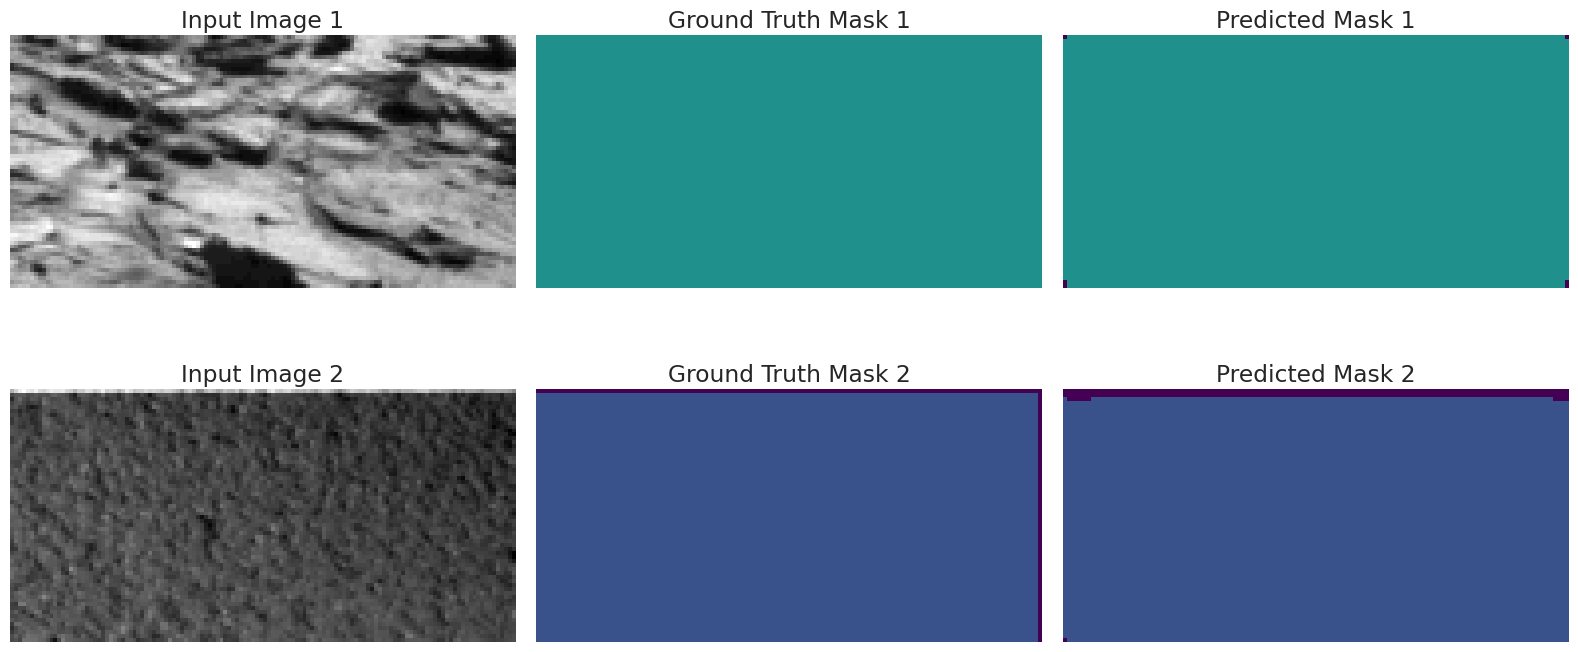

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 144ms/step - accuracy: 0.8175 - loss: 9.6598e-04 - mean_iou: 0.6091 - val_accuracy: 0.8160 - val_loss: 0.0018 - val_mean_iou: 0.6485
Epoch 22/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8181 - loss: 9.4816e-04 - mean_iou: 0.6122 - val_accuracy: 0.8164 - val_loss: 0.0018 - val_mean_iou: 0.6474
Epoch 23/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 124ms/step - accuracy: 0.8166 - loss: 9.8877e-04 - mean_iou: 0.6166 - val_accuracy: 0.8162 - val_loss: 0.0018 - val_mean_iou: 0.6472
Epoch 24/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 124ms/step - accuracy: 0.8227 - loss: 9.2415e-04 - mean_iou: 0.6177 - val_accuracy: 0.8166 - val_loss: 0.0019 - val_mean_iou: 0.6622
Epoch 25/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8199 - loss: 9.5689e-04 - mean_iou: 0

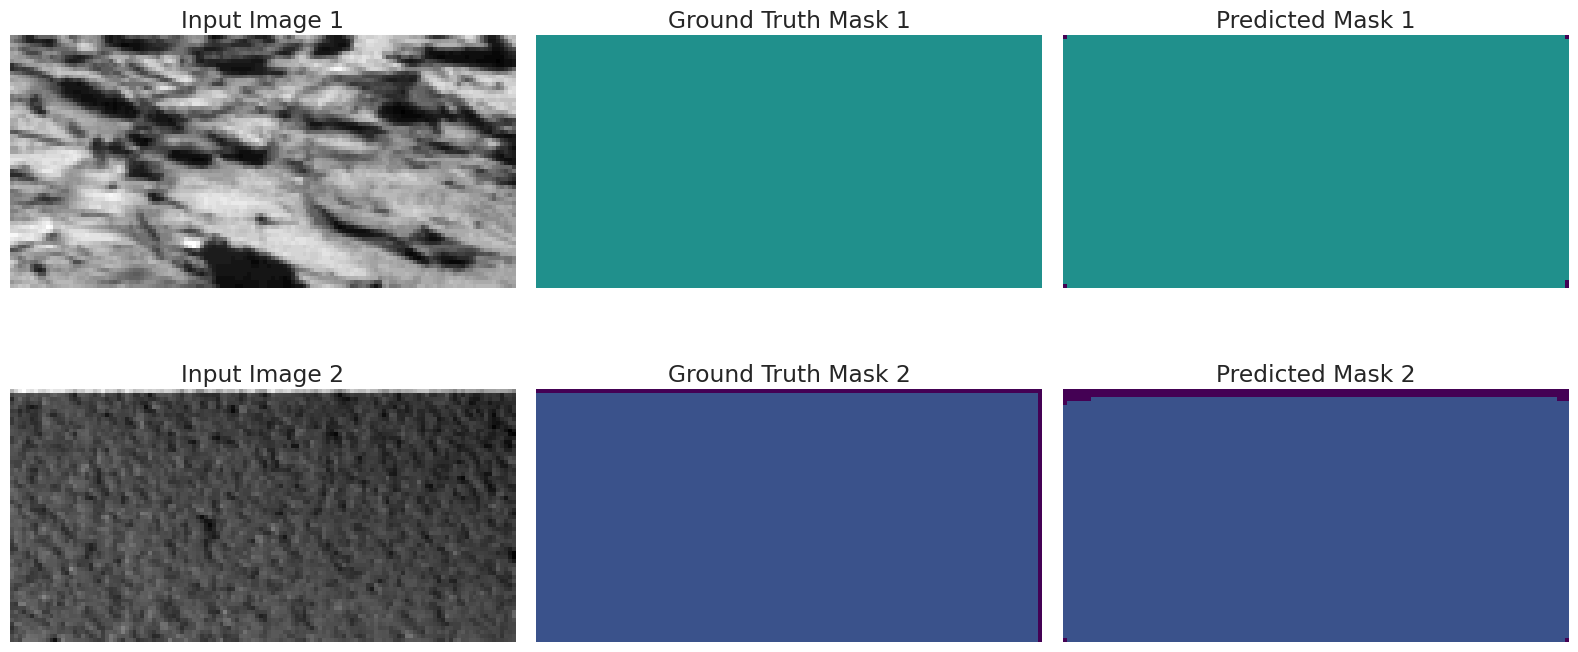

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 150ms/step - accuracy: 0.8234 - loss: 9.2213e-04 - mean_iou: 0.6077 - val_accuracy: 0.8184 - val_loss: 0.0019 - val_mean_iou: 0.6578
Epoch 27/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8209 - loss: 9.4818e-04 - mean_iou: 0.6299 - val_accuracy: 0.8165 - val_loss: 0.0020 - val_mean_iou: 0.6560
Epoch 28/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8198 - loss: 9.2805e-04 - mean_iou: 0.6214 - val_accuracy: 0.8160 - val_loss: 0.0020 - val_mean_iou: 0.6610
Epoch 29/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8216 - loss: 9.0901e-04 - mean_iou: 0.6358 - val_accuracy: 0.8163 - val_loss: 0.0019 - val_mean_iou: 0.6582
Epoch 30/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8234 - loss: 8.8859e-04 - mean_iou: 0

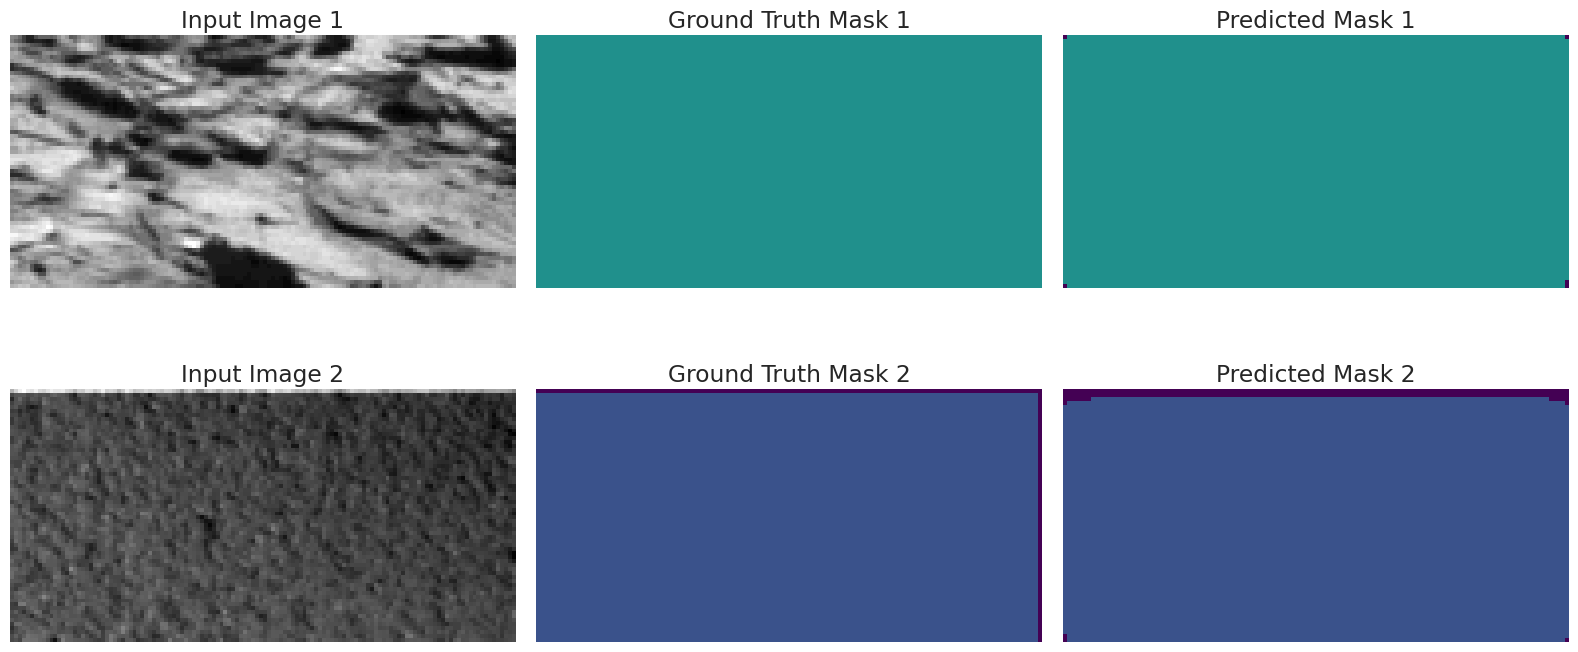

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 144ms/step - accuracy: 0.8237 - loss: 9.2588e-04 - mean_iou: 0.6544 - val_accuracy: 0.8181 - val_loss: 0.0020 - val_mean_iou: 0.6594
Epoch 32/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8248 - loss: 9.2087e-04 - mean_iou: 0.6480 - val_accuracy: 0.8182 - val_loss: 0.0020 - val_mean_iou: 0.6595
Epoch 33/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8284 - loss: 8.8421e-04 - mean_iou: 0.6280 - val_accuracy: 0.8181 - val_loss: 0.0020 - val_mean_iou: 0.6598
Epoch 34/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8274 - loss: 8.8926e-04 - mean_iou: 0.6467 - val_accuracy: 0.8168 - val_loss: 0.0019 - val_mean_iou: 0.6590
Epoch 35/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8232 - loss: 9.0410e-04 - mean_iou: 0

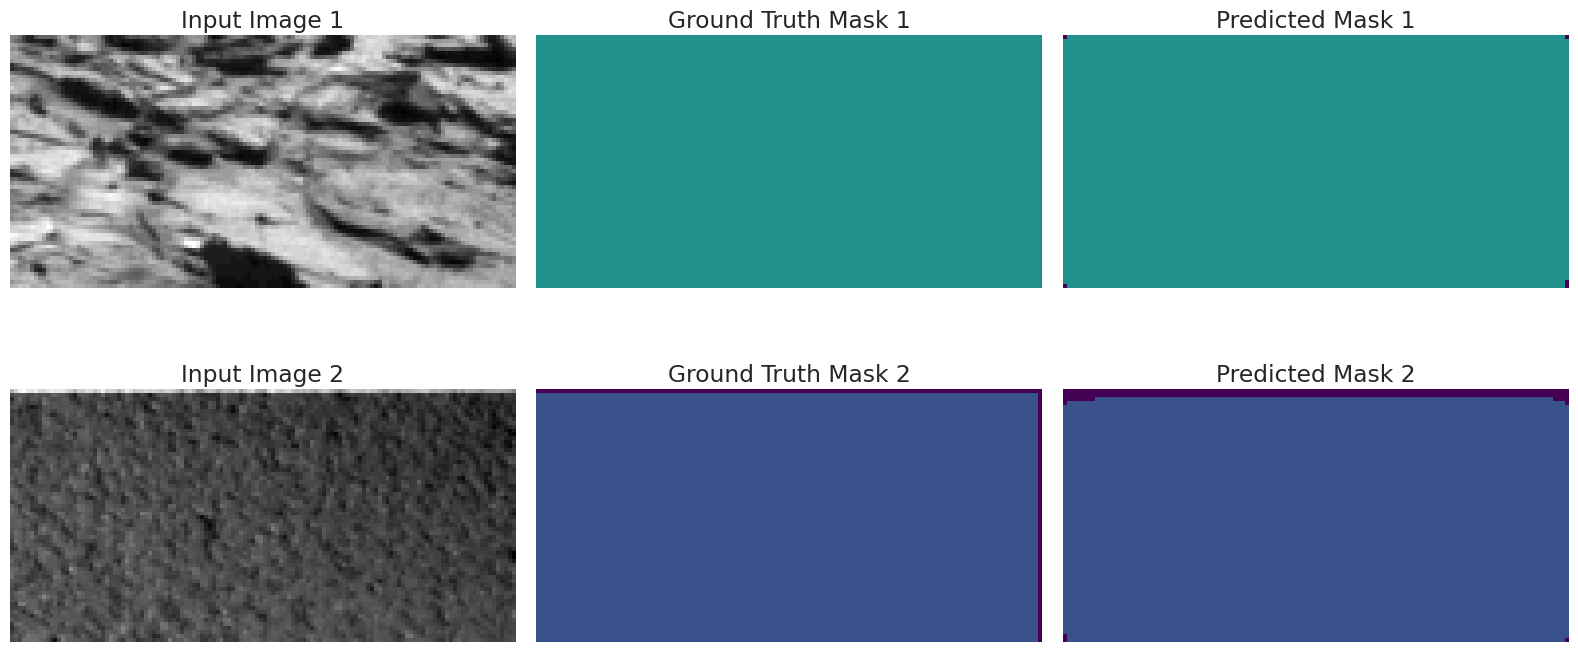

31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 145ms/step - accuracy: 0.8255 - loss: 8.8871e-04 - mean_iou: 0.6359 - val_accuracy: 0.8175 - val_loss: 0.0020 - val_mean_iou: 0.6600
Epoch 37/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8247 - loss: 8.7901e-04 - mean_iou: 0.6406 - val_accuracy: 0.8175 - val_loss: 0.0021 - val_mean_iou: 0.6644
Epoch 38/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8277 - loss: 8.7346e-04 - mean_iou: 0.6419 - val_accuracy: 0.8156 - val_loss: 0.0022 - val_mean_iou: 0.6611
Epoch 39/1000
31/31 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 123ms/step - accuracy: 0.8315 - loss: 8.6261e-04 - mean_iou: 0.6621 - val_accuracy: 0.8154 - val_loss: 0.0021 - val_mean_iou: 0.6549
Final validation Mean Intersection Over Union: 67.72%


In [ ]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
#model.save(model_filename)

# Delete the model to free up resources
#del model

In [ ]:
weights_filename = 'UNet_weights_' + str(final_val_meanIoU) + '.weights.h5'
model.save_weights(weights_filename)

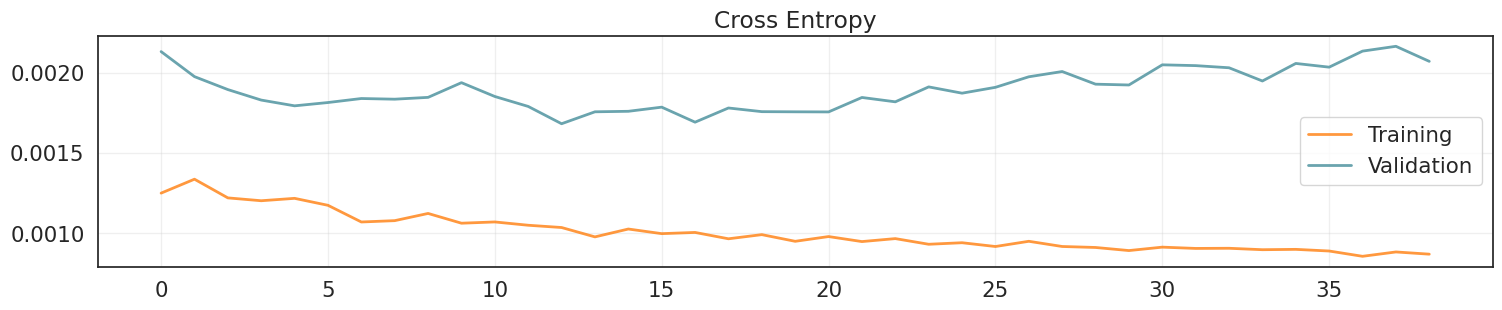

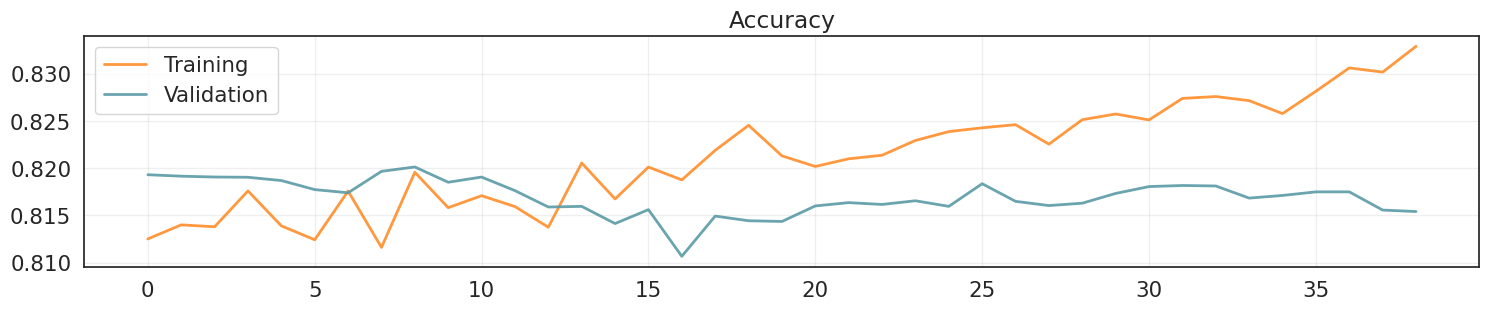

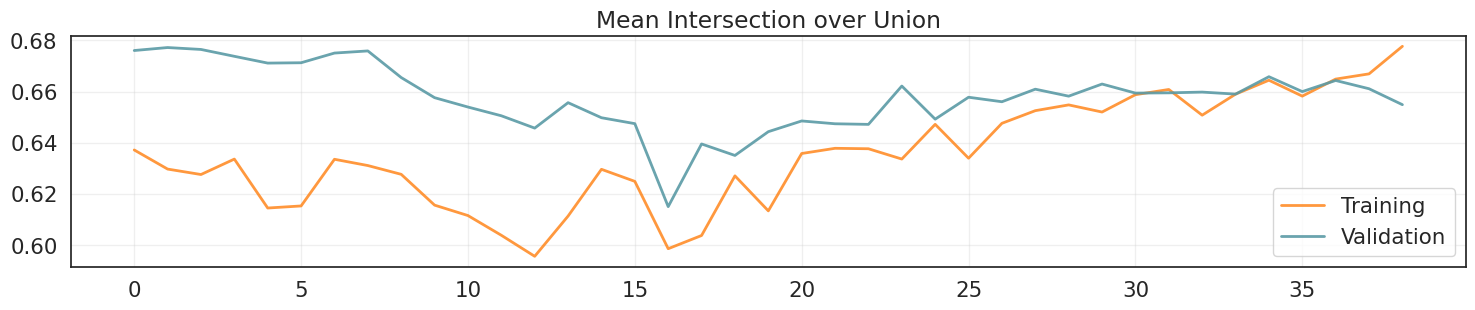

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Above, you can see the progress of the Loss function and of the accuracy and miou for both Training and Validation during the model training

###make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

In [ ]:
# Recreate the model with the original architecture
model = get_unet_model()  # Assuming original architecture
# Load the weights
model.load_weights(weights_filename)

# Compile the model with specified loss, optimizer, and metrics
# Define metrics for each output layer


model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]  # Pass the list of metrics
)

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
#tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

Model: "UNet"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)           ‚îÉ Output Shape         ‚îÉ      Param # ‚îÉ Connected to        ‚îÉ Traina‚Ä¶ ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ input_layer            ‚îÇ (None, 64, 128, 1)   ‚îÇ            0 ‚îÇ -                   ‚îÇ    -    ‚îÇ
‚îÇ (InputLayer)           ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_conv1      ‚îÇ (None, 64, 128, 32)  ‚îÇ          320 ‚îÇ input_layer[0][0]   ‚îÇ    Y    ‚îÇ
‚îÇ (Conv2D)               ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_bn1        ‚îÇ (None, 64, 128, 32)  ‚îÇ          128 ‚îÇ down_block1_conv1[‚Ä¶ ‚îÇ    Y    ‚îÇ
‚îÇ (BatchNormalization)   ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_activatio‚Ä¶ ‚îÇ (None, 64, 128, 32)  ‚îÇ            0 ‚îÇ down_block1_bn1[0]‚Ä¶ ‚îÇ    -    ‚îÇ
‚îÇ (Activation)           ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_conv2      ‚îÇ (None, 64, 128, 32)  ‚îÇ        9,248 ‚îÇ down_block1_activa‚Ä¶ ‚îÇ    Y    ‚îÇ
‚îÇ (Conv2D)               ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_bn2        ‚îÇ (None, 64, 128, 32)  ‚îÇ          128 ‚îÇ down_block1_conv2[‚Ä¶ ‚îÇ    Y    ‚îÇ
‚îÇ (BatchNormalization)   ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ down_block1_activatio‚Ä¶ ‚îÇ (None, 64, 128, 32)  ‚îÇ            0 ‚îÇ down_block1_bn2[0]‚Ä¶ ‚îÇ    -    ‚îÇ
‚îÇ (Activation)           ‚îÇ                      ‚îÇ              ‚îÇ                     ‚îÇ         ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚

 Total params: 2,415,592 (9.21 MB)

 Trainable params: 2,410,728 (9.20 MB)

 Non-trainable params: 4,864 (19.00 KB)

In [ ]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

Test Accuracy: 0.8269
Test Mean Intersection over Union: 0.6562


Above, we can see the results from the predictions made on the test dataset

In [ ]:
preds = model.predict(test_dataset, verbose=0) # Convert the list of predictions to a NumPy array
print(f"Predictions shape: {preds.shape}")

Predictions shape: (243, 64, 128, 5)


4/4 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 40ms/step


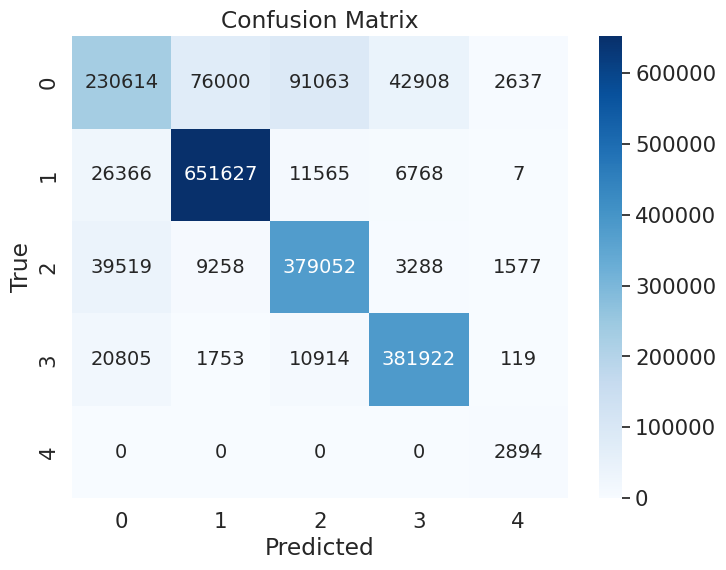

In [ ]:
# Predict on the test set
y_pred = model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred, axis=-1)

# Correctly extract and flatten true labels
y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy().flatten())  # Assuming labels are class indices
y_true = np.array(y_true)

# Flatten predictions
y_pred_classes = y_pred_classes.flatten()

# Compute the confusion matrix without excluding any classes.
cm = confusion_matrix(y_true, y_pred_classes, labels=[0, 1, 2, 3, 4])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])  # Use all class labels
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

We use the trained model to predict on the test set and compute the confusion matrix by comparing the predicted and true labels

Below, we process the test dataset, generating predictions using the trained model. Random samples are visualized, displaying the original image, the true mask, and the predicted mask to evaluate the model's performance

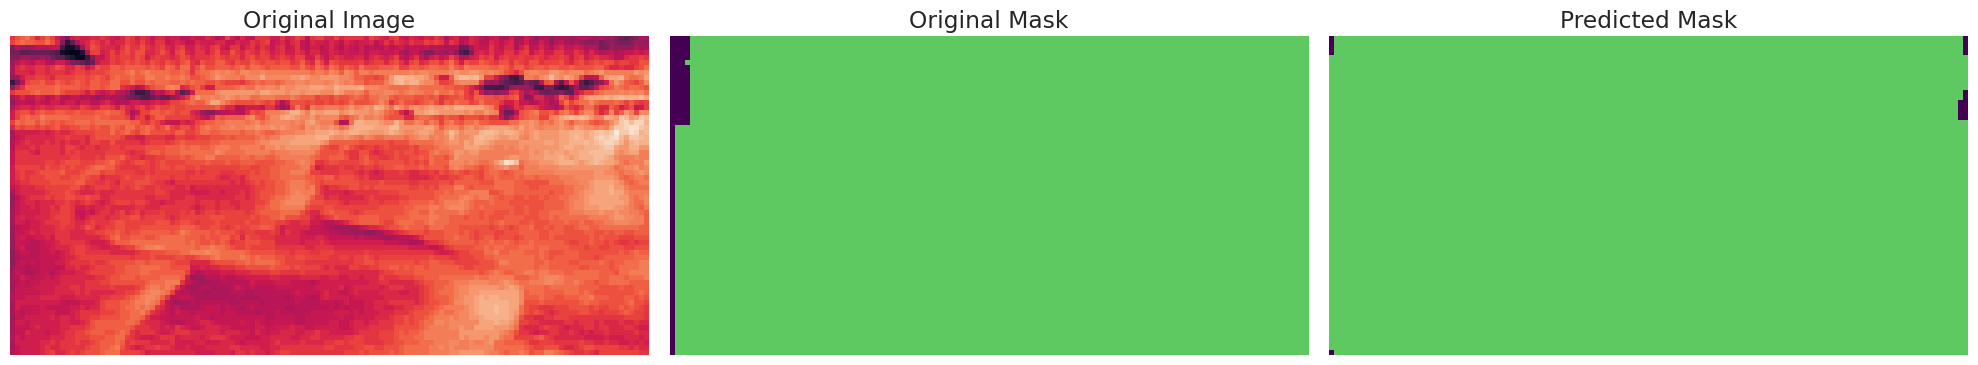

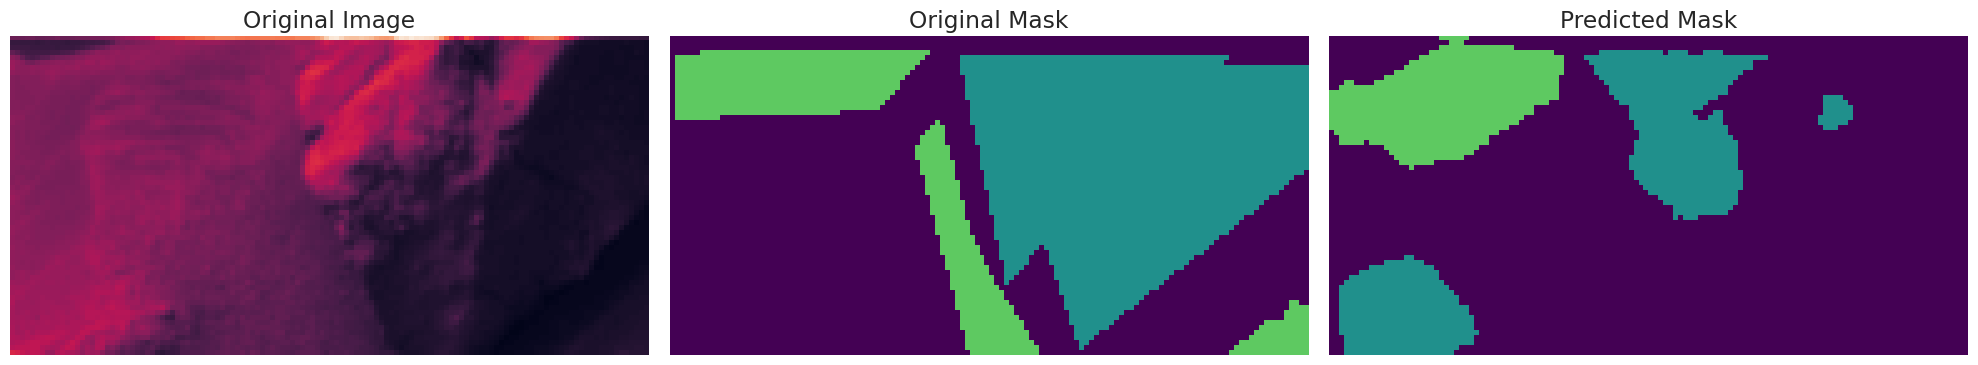

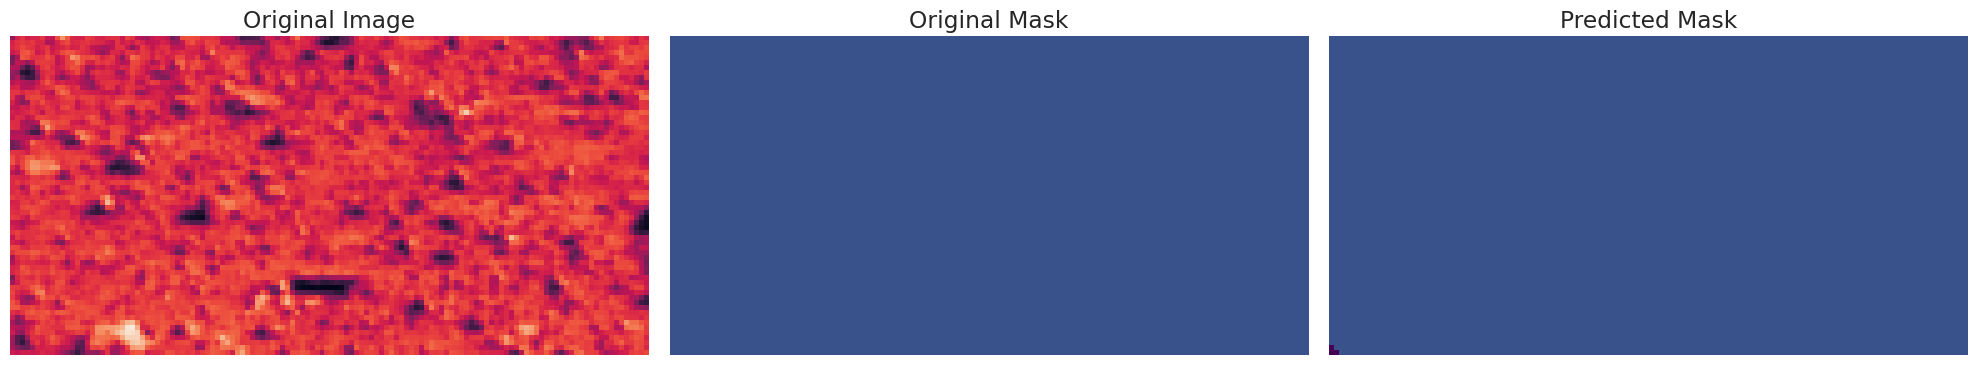

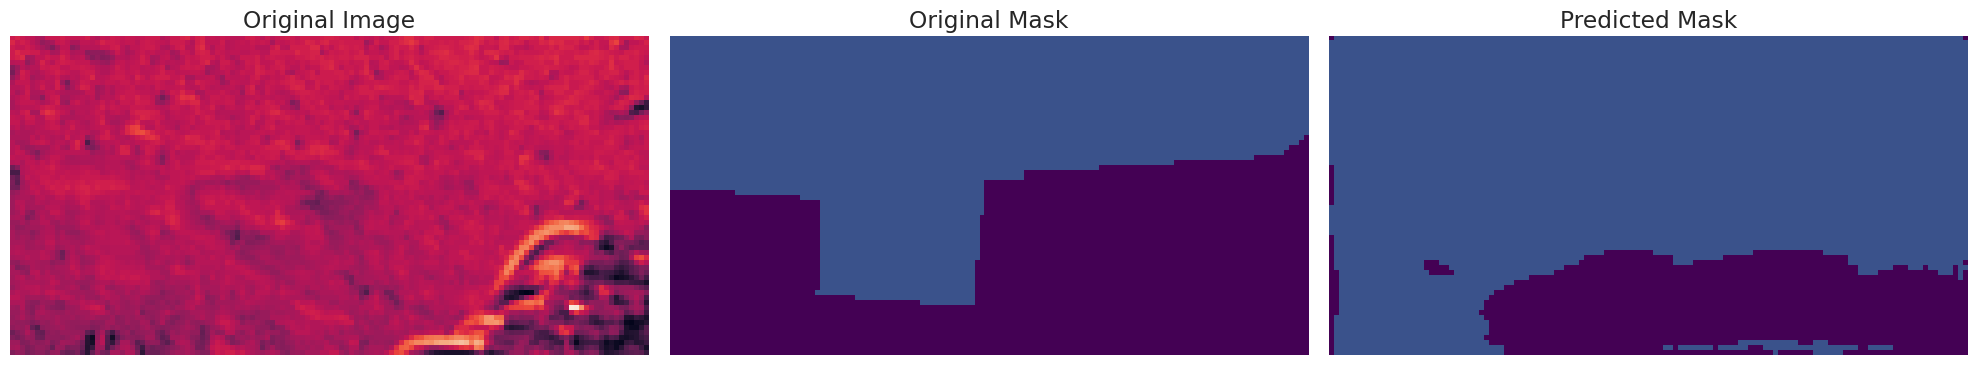

In [ ]:
def plot_triptychs(dataset, model, num_samples=1):
    """
    Plot triptychs (original image, true mask, predicted mask) for samples from a tf.data.Dataset

    Parameters:
    dataset: tf.data.Dataset - The dataset containing image-label pairs
    model: tf.keras.Model - The trained model to generate predictions
    num_samples: int - Number of samples to plot
    """
    # Take samples from the dataset
    samples = dataset.take(num_samples)

    for images, labels in samples:
        # If we have a batch, take the first example
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]
            labels = labels[0:1]

        # Generate predictions
        pred = model.predict(images, verbose=0)
        pred = tf.math.argmax(pred, axis=-1)

        # Create colormap based on number of classes in labels
        num_classes = 5 #ATTENTION ! Modification did here in place of the following 2 lines. TODO: double check
        # labels_np = labels.numpy()
        # num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].set_title("Original Image")
        axes[0].imshow(images[0])
        axes[0].axis('off')

        # Plot original mask
        axes[1].set_title("Original Mask")
        colored_label = apply_colormap(labels[0], colormap)
        axes[1].imshow(colored_label)
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].set_title("Predicted Mask")
        colored_pred = apply_colormap(pred[0], colormap)
        axes[2].imshow(colored_pred)
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Example usage:
# Plot three random samples
plot_triptychs(test_dataset, model, num_samples=7)

In [ ]:
data = np.load("filtered_mars_for_students.npz")
X_test = data["test_set"]
X_test = X_test / 255.0
X_test = np.expand_dims(X_test, axis=-1)  # Add a channel
print(f"X_test shape: {X_test.shape}")

# Predict in batches to avoid OOM errors
batch_size = 32 # Adjust batch size as needed based on your GPU memory
num_samples = X_test.shape[0]
preds = []

for i in range(0, num_samples, batch_size):
    batch_preds = model.predict(X_test[i:i + batch_size], verbose=0)
    preds.extend(np.argmax(batch_preds, axis=-1))

preds = np.array(preds) # Convert the list of predictions to a NumPy array
print(f"Predictions shape: {preds.shape}")


X_test shape: (10022, 64, 128, 1)
Predictions shape: (10022, 64, 128)


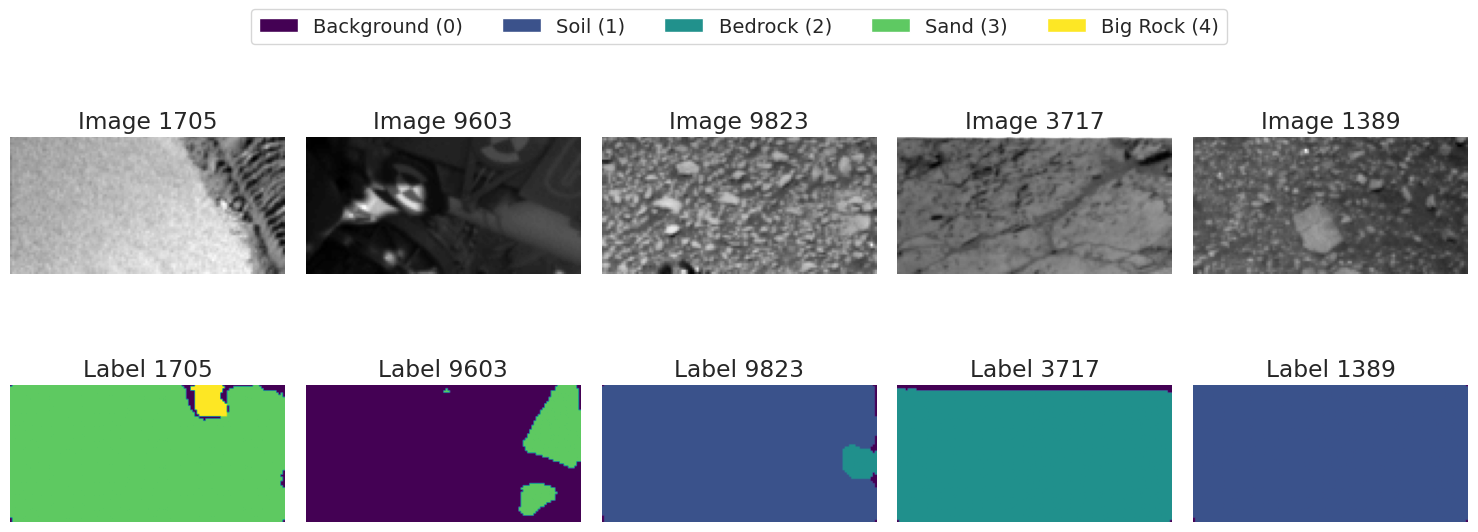

In [ ]:
# Plot 5 random images with labels
plot_random_images_with_labels(X_test, preds, num=5)


Distribuzione delle classi: {0: 19522285, 1: 25871784, 2: 22183269, 3: 14243187, 4: 279699}


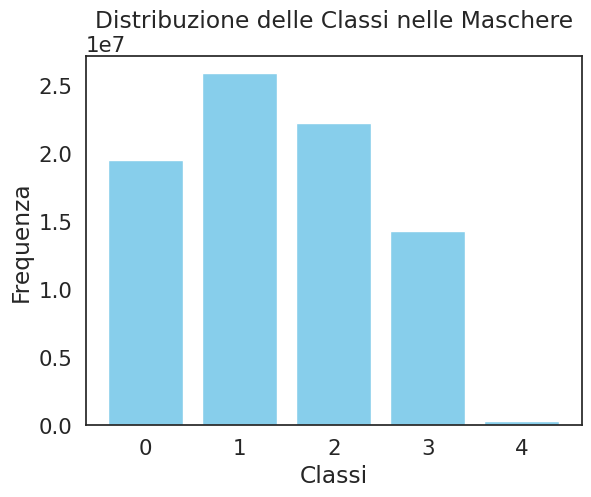

Numero di classi uniche nel dataset: 5


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate class frequencies
unique, counts = np.unique(preds, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Visualization
print("Distribuzione delle classi:", class_distribution)

# Bar plot
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Classi')
plt.ylabel('Frequenza')
plt.title('Distribuzione delle Classi nelle Maschere')
plt.xticks(list(class_distribution.keys()))
plt.show()

# Number of unique classes
print(f"Numero di classi uniche nel dataset: {len(class_distribution)}")


Above, we calculate and visualize the distribution of predicted classes, providing insights into class frequencies, and print the number of unique predicted classes to assess the model's output diversity

##üóÇÔ∏èpreparing the submission

In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

print(f"Submission file saved to: {submission_filename}")
# from google.colab import files
# files.download(submission_filename)

Submission file saved to: submission_UNet_67.72.csv
